In [1]:
# Cell 1 - Imports, config, and project paths
from __future__ import annotations
import os, sys, gc, math, json, time, psutil, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

try:
    from torch.utils.tensorboard import SummaryWriter
    HAVE_TB = True
except Exception:
    HAVE_TB = False

import optuna
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit

# ---- project config ----
config_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(config_path)
import config as config

# ---- device & precision ----
USE_GPU = torch.cuda.is_available()
DEVICE  = torch.device("cuda" if USE_GPU else "cpu")
AMP_DTYPE = torch.bfloat16 if (USE_GPU and torch.cuda.is_bf16_supported()) else torch.float16

torch.backends.cudnn.benchmark = True  # fast conv autotune
RNG_SEED = 42
torch.manual_seed(RNG_SEED); np.random.seed(RNG_SEED)

# Prefer TF32 / high-precision matmuls on Ampere+ for faster convs without accuracy loss
if USE_GPU:
    try:
        torch.set_float32_matmul_precision('high')
    except Exception:
        pass


print(f"Device: {DEVICE} | AMP dtype: {AMP_DTYPE} | CUDA mem (GB): "
      f"{(torch.cuda.get_device_properties(0).total_memory/1e9):.2f}" if USE_GPU else "CPU only")

# ---- Paths ----
CSV_PATH = str(config.PROCESSED_CSV)
OUTPUT_PLOT = str(config.XGB_CONFUSION_MATRIX_PLOT).replace("xgb", "tcn")
OUTPUT_PREDICTIONS = str(config.PREDICTIONS_CSV).replace("xgb", "tcn")
OUTPUTS_DIR = Path(str(config.OUTPUTS_DIR)) / "tcn"
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

# Primary artifacts
MODEL_PATH   = OUTPUTS_DIR / "tcn_model.pt"            # consolidated "best" (for inference)
PARAMS_PATH  = OUTPUTS_DIR / "tcn_best_params.json"
TB_DIR       = OUTPUTS_DIR / "tb"

# --- Simple feature toggles ---
SAVE_CHECKPOINTS   = True     # turn all saving behaviors on/off
SAVE_BEST          = True     # save best-on-improvement during training
SAVE_LAST          = True     # save last-epoch snapshot every epoch
RESUME_TRAINING    = False     # resume from TRAIN_STATE_PATH if it exists
EXPORT_TORCHSCRIPT = True     # export TorchScript after training
EXPORT_ONNX        = False    # export ONNX after training

# Extra checkpoint/export paths
MODEL_BEST_PATH   = OUTPUTS_DIR / "tcn_model_best.pt"   # best-on-improvement (minimal)
MODEL_LAST_PATH   = OUTPUTS_DIR / "tcn_model_last.pt"   # last-epoch weights (minimal)
TRAIN_STATE_PATH  = OUTPUTS_DIR / "tcn_train_state.pt"  # full state for resume
SCRIPTED_PATH     = OUTPUTS_DIR / "tcn_scripted.pt"
ONNX_PATH         = OUTPUTS_DIR / "tcn.onnx"

# ---- Inference/Calibration toggles ----
PREFER_CKPT = "best"      # {"best", "best_on_improvement", "last"} when loading for inference
AUTO_FALLBACK = True      # fall back if preferred file missing

TEMP_CALIBRATE = True     # fit temperature on validation logits
TEMP_SAVE = True          # persist learned temperature
TEMP_APPLY_ON_VAL = True  # apply T on Cell 10 validation metrics/plots
TEMP_APPLY_ON_INFER = True# apply T in inference (Cell 12)
TEMP_PATH = OUTPUTS_DIR / "tcn_temp.pt"




Device: cuda | AMP dtype: torch.bfloat16 | CUDA mem (GB): 34.19


c:\Users\reyno\Documents\GitHub\Project-BLD\venv311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WINDOW = 2048          # long window (minutes); tune larger for more context
STRIDE = 4            # step between adjacent samples; increase to thin training set
MIN_EFF_LEN = WINDOW  # require at least WINDOW points per item


In [2]:
# Cell 2 - Parse, label, sort, and downcast input data
df = pd.read_csv(CSV_PATH).sort_values("timestamp").reset_index(drop=True)

if "tradable" not in df.columns:
    df["tradable"] = 1
df["tradable"] = df["tradable"].astype("int8")

# Downcast for RAM headroom (we’ll keep timestamp/mid_price native where needed)
to_cast = [c for c in df.select_dtypes("float64").columns if c not in ("timestamp","mid_price")]
if to_cast:
    df[to_cast] = df[to_cast].astype("float32")

# ---------- Labels (identical to your REPLACE Cell 5) ----------
UP_TAU = 0.2
DN_TAU_BASE = 0.05
USE_VOL_SCALED_DN = False
VOL_COL = "vol_60"
DN_TAU_MIN = 0.015
DN_VOL_MULT = 0.75

if {"target_q_up_rel","target_q_dn_rel"}.issubset(df.columns):
    up_rel_series = df["target_q_up_rel"].astype(np.float32)
    dn_rel_series = df["target_q_dn_rel"].astype(np.float32)
else:
    up_rel_series = df["target_max_rel"].astype(np.float32)
    dn_rel_series = (-df["target_min_rel"]).astype(np.float32)

if USE_VOL_SCALED_DN and (VOL_COL in df.columns):
    vol = df[VOL_COL].astype(np.float32).fillna(0.0)
    dn_tau_eff = np.maximum(DN_TAU_MIN, DN_VOL_MULT * vol.values)
else:
    dn_tau_eff = np.full(len(df), DN_TAU_BASE, dtype=np.float32)

def to_dir_asym(u: float, d: float, t: float) -> int:
    if np.isfinite(u) and (u >= UP_TAU): return 1
    if np.isfinite(d) and (d >= t):      return -1
    return 0

y_dir = np.fromiter((to_dir_asym(u,d,t) for u,d,t in zip(up_rel_series.values,
                                                         dn_rel_series.values, dn_tau_eff)),
                    count=len(df), dtype=np.int8)
_map = {-1:0, 0:1, 1:2}
_inv = np.array([-1,0,1])
y = np.fromiter((_map[int(v)] for v in y_dir), count=y_dir.shape[0], dtype=np.int8)

counts = np.bincount(y, minlength=3)
print(f"Rows: {len(df):,} | Class counts (−1,0,1): {{-1:{int(counts[0])}, 0:{int(counts[1])}, 1:{int(counts[2])}}}")

# ---------- Feature matrix (leak-proof) ----------
passthrough_base = {"item","timestamp","mid_price","tradable",
                    "target_min_abs","target_max_abs","target_min_rel","target_max_rel"}
leak_prefixes = ("target_",)
leak_cols = {c for c in df.columns if any(c.startswith(p) for p in leak_prefixes)}
passthrough = passthrough_base | leak_cols

feature_cols = [c for c in df.columns
                if (c not in passthrough) and pd.api.types.is_numeric_dtype(df[c])]
_bad = [c for c in feature_cols if c.startswith("target_")]
assert not _bad, f"Leakage detected: target_* in features: {_bad}"

X = df[feature_cols]
if any(X.dtypes != "float32"):
    X = X.astype("float32", copy=False)

finite_mask = np.isfinite(X.to_numpy(copy=False)).all(axis=1)
tradable_mask = (df["tradable"].to_numpy(copy=False) == 1)
mask = finite_mask & tradable_mask

X = X.loc[mask]
y_dir = y_dir[mask]
y = np.fromiter((_map[int(v)] for v in y_dir), count=y_dir.shape[0], dtype=np.int8)
df = df.loc[mask].reset_index(drop=True)

counts = np.bincount(y, minlength=3)
print(f"[labels] Post-mask class counts: {{-1:{int(counts[0])}, 0:{int(counts[1])}, 1:{int(counts[2])}}}")
print(f"[leak-check] Excluded {len(leak_cols)} leak-prone columns from features.")


Rows: 27,405,019 | Class counts (−1,0,1): {-1:4822405, 0:17434503, 1:5148111}
[labels] Post-mask class counts: {-1:4499997, 0:16296699, 1:4764492}
[leak-check] Excluded 8 leak-prone columns from features.


In [4]:
# Cell 3 - Split and create windows 
def purged_time_splits(n_rows: int, n_splits: int = 5, embargo: int = 0):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    idx = np.arange(n_rows)
    for tr, va in tscv.split(idx):
        if embargo > 0:
            va_start = va.min()
            tr = tr[tr < max(0, va_start - embargo)]
        yield tr, va

splits = list(purged_time_splits(len(X), n_splits=5))
train_idx, val_idx = splits[-1]

# --------- Build item-wise sequence end indices ---------
# Each sample is a window ending at t (label=y[t]); windows do not cross items.
WINDOW = 2048          # long window (minutes); tune larger for more context
STRIDE = 4            # step between adjacent samples; increase to thin training set
MIN_EFF_LEN = WINDOW  # require at least WINDOW points per item

meta = df[['item','timestamp']].to_numpy()
items = df['item'].to_numpy()
item_to_pos = {}
for i, it in enumerate(items):
    if it not in item_to_pos:
        item_to_pos[it] = []
    item_to_pos[it].append(i)
# convert to np arrays
for k in item_to_pos:
    item_to_pos[k] = np.asarray(item_to_pos[k], dtype=np.int64)

# Build global list of valid end indices per item
end_indices = []
end_indices_val = []
end_indices_tr  = []

val_mask = np.zeros(len(df), dtype=bool); val_mask[val_idx] = True
for it, idxs in item_to_pos.items():
    if len(idxs) < MIN_EFF_LEN: 
        continue
    # valid window ends for this item
    ends = idxs[WINDOW-1::STRIDE]
    end_indices.extend(ends.tolist())
    # assign to train/val by end index membership
    end_indices_val.extend([e for e in ends if val_mask[e]])
    end_indices_tr.extend([e for e in ends if not val_mask[e]])

end_indices = np.asarray(end_indices, dtype=np.int64)
end_indices_tr = np.asarray(end_indices_tr, dtype=np.int64)
end_indices_val = np.asarray(end_indices_val, dtype=np.int64)

print(f"Total seq samples: {len(end_indices):,} | train: {len(end_indices_tr):,} | val: {len(end_indices_val):,}")


NameError: name 'X' is not defined

In [4]:
# Cell 4 - Construct dataset and dataloaders
class SeqDataset(Dataset):
    def __init__(self, X_df: pd.DataFrame, y_enc: np.ndarray, df_meta: pd.DataFrame,
                 end_idx: np.ndarray, window: int):
        self.X_np = X_df.to_numpy(copy=False)  # float32
        self.y = y_enc
        self.meta = df_meta
        self.end_idx = end_idx
        self.window = window
        self.nfeat = self.X_np.shape[1]

    def __len__(self):
        return len(self.end_idx)

    def __getitem__(self, i):
        e = int(self.end_idx[i])
        s = e - self.window + 1
        x = self.X_np[s:e+1, :]                 # [T, C]
        y = int(self.y[e])
        # meta for assembling preds later
        ts = self.meta['timestamp'].iat[e]
        it = self.meta['item'].iat[e]
        mid = self.meta['mid_price'].iat[e] if 'mid_price' in self.meta else np.nan
        return x, y, ts, it, mid

def _guess_batch_size(nfeat, window, bytes_per_el=2):  # ~fp16 activations on GPU
    # crude estimator for 32GB VRAM with optimizer/grad buffers
    # memory ≈ B * window * nfeat * bytes * multipliers
    multiplier = 14  # activations + grads + optimizer states
    target_bytes = 28 * (4096**3)  # leave ~4GB headroom
    est = int(max(128, target_bytes // (window * nfeat * bytes_per_el * multiplier)))
    return min(128, est)

NFEAT = X.shape[1]
BATCH_SIZE = min(256, _guess_batch_size(NFEAT, WINDOW))
print(f"Auto batch size ≈ {BATCH_SIZE} (nfeat={NFEAT}, window={WINDOW})")

ds_tr  = SeqDataset(X, y, df[['timestamp','item','mid_price']], end_indices_tr, WINDOW)
ds_val = SeqDataset(X, y, df[['timestamp','item','mid_price']], end_indices_val, WINDOW)


num_workers = 0                     # ← avoid Windows spawn copies
dl_tr = DataLoader(
    ds_tr,
    batch_size=BATCH_SIZE,
    shuffle=True,                # <— use shuffle, not WeightedRandomSampler
    num_workers=num_workers,
    pin_memory=False
)
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False,
                    num_workers=0, pin_memory=False, drop_last=False)

print(f"[loader] train samples={len(ds_tr):,} | batches/epoch={len(dl_tr):,} | batch_size={BATCH_SIZE}")
print(f"[loader] val   samples={len(ds_val):,} | batches/epoch={len(dl_val):,}")




Auto batch size ≈ 128 (nfeat=99, window=2048)
[loader] train samples=5,008,713 | batches/epoch=39,131 | batch_size=128
[loader] val   samples=1,065,052 | batches/epoch=8,321


In [5]:
# Cell 5 - Model Definitions
class Chomp1d(nn.Module):
    # Trim right padding to keep causality strict
    def __init__(self, chomp):
        super().__init__()
        self.chomp = chomp
    def forward(self, x):
        return x[..., :-self.chomp] if self.chomp > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k, dilation, dropout=0.10, groups=1):
        super().__init__()
        pad = (k - 1) * dilation  # causal padding (right side)
        self.conv1 = nn.Conv1d(in_ch, out_ch, k, padding=pad, dilation=dilation, groups=groups)
        self.chomp1 = Chomp1d(pad)
        self.norm1  = nn.GroupNorm(num_groups=min(8, out_ch), num_channels=out_ch)
        self.drop1  = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_ch, out_ch, k, padding=pad, dilation=dilation, groups=groups)
        self.chomp2 = Chomp1d(pad)
        self.norm2  = nn.GroupNorm(num_groups=min(8, out_ch), num_channels=out_ch)
        self.drop2  = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.act = nn.SiLU()

    def forward(self, x):
        y = self.conv1(x); y = self.chomp1(y); y = self.norm1(y); y = self.act(y); y = self.drop1(y)
        y = self.conv2(y); y = self.chomp2(y); y = self.norm2(y); y = self.drop2(y)
        res = self.downsample(x)
        return self.act(y + res)

class TCN(nn.Module):
    def __init__(self, nfeat, num_classes=3, channels=256, levels=6, k=5,
                 dropout=0.10, groups=1):
        super().__init__()
        layers = []
        in_ch = nfeat
        for i in range(levels):
            dilation = 2 ** i
            out_ch = channels
            layers.append(TemporalBlock(in_ch, out_ch, k=k, dilation=dilation,
                                        dropout=dropout, groups=groups))
            in_ch = out_ch
        self.net = nn.Sequential(*layers)
        self.head = nn.Sequential(
            nn.Conv1d(in_ch, in_ch, kernel_size=1),
            nn.SiLU(),
            nn.Conv1d(in_ch, num_classes, kernel_size=1)
        )

    def forward(self, x):      # x: [B, T, C]
        x = x.transpose(1,2)   # -> [B, C, T]
        y = self.net(x)        # [B, H, T]
        logits = self.head(y)  # [B, num_classes, T]
        # --- CHANGE: return full sequence logits ---
        return logits.transpose(1, 2)  # [B, T, num_classes]


In [6]:
# Cell 6 - Model helpers
class LabelSmoothingCE(nn.Module):
    def __init__(self, eps=0.05, weight=None):
        super().__init__()
        self.eps = eps
        self.register_buffer("weight", None if weight is None else torch.tensor(weight, dtype=torch.float32))

    def forward(self, logits, target):
        n_cls = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        if self.weight is not None:
            w = self.weight.to(logits.device)  # <-- ensure same device
            with torch.no_grad():
                true_dist = torch.zeros_like(logp).fill_(self.eps/(n_cls-1))
                true_dist.scatter_(1, target.unsqueeze(1), 1-self.eps)
            loss = -(true_dist * logp)
            loss = loss * w.view(1, -1)
            return loss.sum(dim=1).mean()
        else:
            return F.cross_entropy(logits, target, label_smoothing=self.eps)


class TemperatureScaler(nn.Module):
    def __init__(self): 
        super().__init__()
        self.t = nn.Parameter(torch.ones([]))
    def forward(self, logits):
        return logits / self.t.clamp_min(1e-3)

def print_mem(prefix=""):
    vm = psutil.virtual_memory()
    cpu_free = (vm.available/1e9)
    if USE_GPU:
        alloc = torch.cuda.memory_allocated()/1e9
        reserved = torch.cuda.memory_reserved()/1e9
        print(f"{prefix} CPU free ~{cpu_free:,.1f} GB | CUDA alloc {alloc:.2f} GB / reserved {reserved:.2f} GB")
    else:
        print(f"{prefix} CPU free ~{cpu_free:,.1f} GB | CUDA N/A")

def evaluate(model, loader):
    model.eval()
    ys, yhs = [], []
    with torch.no_grad():
        for xb, yb, *_ in loader:
            xb = xb.to(DEVICE, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)
            with autocast(enabled=USE_GPU, dtype=AMP_DTYPE):
                logits = model(xb)
            yhat = logits.argmax(dim=1)
            ys.append(yb.detach().cpu().numpy())
            yhs.append(yhat.detach().cpu().numpy())
    y_true = np.concatenate(ys) if ys else np.array([], dtype=int)
    y_pred = np.concatenate(yhs) if yhs else np.array([], dtype=int)
    if len(y_true)==0: 
        return 0.0, y_true, y_pred
    f1 = f1_score(y_true, y_pred, average="macro")
    return f1, y_true, y_pred
# ---------- Checkpoint & export helpers ----------

def save_checkpoint(model, opt, sched, scaler, epoch, best_f1, used_params, path: Path):
    if not SAVE_CHECKPOINTS: 
        return
    ckpt = {
        "state_dict": model.state_dict(),
        "epoch": int(epoch),
        "best_f1": float(best_f1),
        "params": used_params,
        "device": str(DEVICE),
        "amp_dtype": str(AMP_DTYPE),
        "rng_seed": RNG_SEED,
    }
    if opt is not None:   ckpt["optimizer"] = opt.state_dict()
    if sched is not None: ckpt["scheduler"] = sched.state_dict()
    if scaler is not None:
        try: ckpt["scaler"] = scaler.state_dict()
        except Exception: ckpt["scaler"] = None
    torch.save(ckpt, path)

def load_checkpoint(model, path: Path, opt=None, sched=None, scaler=None, map_location=None):
    ckpt = torch.load(str(path), map_location=map_location or DEVICE)
    model.load_state_dict(ckpt["state_dict"])
    if opt   is not None and "optimizer" in ckpt and ckpt["optimizer"] is not None: opt.load_state_dict(ckpt["optimizer"])
    if sched is not None and "scheduler" in ckpt and ckpt["scheduler"] is not None: sched.load_state_dict(ckpt["scheduler"])
    if scaler is not None and "scaler"    in ckpt and ckpt["scaler"]    is not None:
        try: scaler.load_state_dict(ckpt["scaler"])
        except Exception: pass
    return ckpt.get("epoch", 0), ckpt.get("best_f1", -1.0), ckpt.get("params", None)

@torch.no_grad()
def export_for_inference(model, nfeat: int, window: int, scripted_path: Path, onnx_path: Path | None = None):
    if not (EXPORT_TORCHSCRIPT or EXPORT_ONNX):
        return
    model_eval = model.to(DEVICE).eval()
    example = torch.zeros(1, window, nfeat, device=DEVICE)
    if EXPORT_TORCHSCRIPT:
        scripted = torch.jit.trace(model_eval, example, check_inputs=[torch.randn_like(example)])
        scripted.save(str(scripted_path))
        print(f"[export] TorchScript -> {scripted_path}")
    if EXPORT_ONNX:
        torch.onnx.export(
            model_eval, example, str(onnx_path),
            input_names=["x"], output_names=["logits_last"],
            opset_version=17, dynamic_axes={"x": {0:"batch",1:"time"}, "logits_last": {0:"batch"}}
        )
        print(f"[export] ONNX -> {onnx_path}")
# ---- Temperature I/O helpers ----
def save_temperature(temp_module: nn.Module, path: Path):
    if TEMP_SAVE:
        torch.save({"t": float(temp_module.t.detach().cpu())}, path)
        print(f"[cal] saved temperature -> {path}")

def load_temperature(path: Path, device=DEVICE) -> nn.Module | None:
    if not path.exists(): 
        return None
    d = torch.load(str(path), map_location=device)
    m = TemperatureScaler().to(device)
    with torch.no_grad():
        m.t.copy_(torch.tensor(d.get("t", 1.0), device=device))
    print(f"[cal] loaded temperature={float(m.t.detach().cpu()):.3f} from {path}")
    return m




In [13]:
# Cell 7 - Parameters, setup, class balancing, and more helpers
# ---- knobs (edit freely) ----
USE_OPTUNA             = False     # manual tuning default ON, Optuna OFF
N_TRIALS               = 20
MAX_EPOCHS             = 2
EARLY_STOP_PATIENCE    = 1
BASE_LR                = 1e-3
WEIGHT_DECAY           = 1e-3
CHANNELS               = 256
LEVELS                 = 8
KERNEL_SIZE            = 7         # long receptive field with dilation
DROPOUT                = 0.15
GROUPS                 = 1         # depthwise/grouped conv; >1 can improve speed

# class weights from train distribution
tr_counts = np.bincount(y[end_indices_tr], minlength=3)
tr_counts = np.maximum(tr_counts, 1)
w_per_class = tr_counts.sum() / (3.0 * tr_counts)
print(f"Train class weights: {w_per_class.round(4)}  (order enc 0/1/2 == {-1,0,1})")

def build_model(params=None):
    p = dict(
        nfeat=NFEAT,
        num_classes=3,
        channels=CHANNELS,
        levels=LEVELS,
        k=KERNEL_SIZE,
        dropout=DROPOUT,
        groups=GROUPS
    )
    if params: p.update(params)
        # Groups must divide both in_channels (nfeat) and out_channels (channels) for Conv1d
    if int(p['groups']) > 1 and ((int(p['nfeat']) % int(p['groups']) != 0) or (int(p['channels']) % int(p['groups']) != 0)):
        # If using Optuna, prune; otherwise, fall back to groups=1
        try:
            raise optuna.TrialPruned(f"Invalid groups: nfeat={p['nfeat']}, channels={p['channels']}, groups={p['groups']}")
        except Exception:
            p['groups'] = 1
    model = TCN(nfeat=p['nfeat'], num_classes=3, channels=p['channels'], levels=p['levels'],
                k=p['k'], dropout=p['dropout'], groups=p['groups']).to(DEVICE)
    return model, p


def train_one(model, params, log_dir=None, used_params=None):
    # --- deprecation-safe scaler ---
    scaler = (torch.amp.GradScaler('cuda') if USE_GPU else torch.amp.GradScaler(enabled=False))

    opt = torch.optim.AdamW(model.parameters(), lr=params.get('lr', BASE_LR),
                            weight_decay=params.get('weight_decay', WEIGHT_DECAY), eps=1e-8)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, MAX_EPOCHS-1))
    criterion = LabelSmoothingCE(eps=0.05, weight=w_per_class)
    writer = SummaryWriter(log_dir=str(log_dir)) if (HAVE_TB and log_dir is not None) else None

    # --- resume if requested/available ---
    start_epoch = 1
    best_f1 = -1.0
    if RESUME_TRAINING and TRAIN_STATE_PATH.exists():
        try:
            e_prev, best_prev, _ = load_checkpoint(model, TRAIN_STATE_PATH, opt=opt, sched=sched, scaler=scaler)
            start_epoch = int(e_prev) + 1
            best_f1 = float(best_prev)
            print(f"[resume] {TRAIN_STATE_PATH} @epoch={e_prev}, best_f1={best_prev:.4f}")
        except Exception as e:
            print(f"[resume] failed: {e}")

    best_state = None
    no_improve = 0
    t0 = time.time()

    print_mem("[telemetry] start")
    for epoch in range(start_epoch, MAX_EPOCHS+1):
        model.train()
        loss_meter = 0.0
        n_seen = 0
        t_ep0 = time.time()

        steps = len(dl_tr)
        tick_every = max(1, steps // 20)
        t_batch0 = time.time()

        for step, (xb, yb, *_) in enumerate(dl_tr, start=1):
            xb = xb.to(DEVICE, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=USE_GPU, dtype=AMP_DTYPE):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt); scaler.update()

            loss_meter += float(loss.detach().cpu()) * xb.size(0)
            n_seen += xb.size(0)

            if (step % tick_every) == 0 or step == 1:
                dt = time.time() - t_batch0
                ips = (tick_every * xb.size(0)) / max(dt, 1e-6) if step > 1 else float('nan')
                pct = 100.0 * step / max(1, steps)
                print(f"[ep {epoch:02d}] {pct:5.1f}%  step {step:>6}/{steps:<6}  "
                      f"loss(avg)={loss_meter/max(1,n_seen):.4f}  {ips:,.0f} samp/s")
                t_batch0 = time.time()

        sched.step()
        f1_val, _, _ = evaluate(model, dl_val)
        loss_avg = loss_meter / max(1, n_seen)

        # --- validation loss ---
        val_loss_meter = 0.0
        val_seen = 0
        model.eval()
        with torch.no_grad():
            for xb, yb, *_ in dl_val:
                xb = xb.to(DEVICE, non_blocking=True)
                yb = yb.to(DEVICE, non_blocking=True)
                with torch.amp.autocast('cuda', enabled=USE_GPU, dtype=AMP_DTYPE):
                    logits = model(xb)
                    vloss = criterion(logits, yb)
                val_loss_meter += float(vloss.detach().cpu()) * xb.size(0)
                val_seen += xb.size(0)
        val_loss_avg = val_loss_meter / max(1, val_seen)

        if writer:
            writer.add_scalar("loss/train", loss_avg, epoch)
            writer.add_scalar("loss/val", val_loss_avg, epoch)  # NEW
            writer.add_scalar("f1/val_macro", f1_val, epoch)
            writer.add_scalar("lr", sched.get_last_lr()[0], epoch)

        dt = time.time()-t_ep0
        print(f"[epoch {epoch:02d}] loss(train)={loss_avg:.4f} | loss(val)={val_loss_avg:.4f} | valF1={f1_val:.4f} | "
            f"lr={sched.get_last_lr()[0]:.2e} | {dt:.1f}s")

        print_mem("    ")

        # --- save 'last' for resume + minimal last weights
        if SAVE_CHECKPOINTS and SAVE_LAST:
            save_checkpoint(model, opt, sched, scaler, epoch, max(best_f1, f1_val),
                            used_params or params, TRAIN_STATE_PATH)
            save_checkpoint(model, None, None, None, epoch, f1_val,
                            used_params or params, MODEL_LAST_PATH)

        # --- best-on-improvement
        if SAVE_CHECKPOINTS and SAVE_BEST and (f1_val > best_f1 + 1e-4):
            best_f1 = f1_val
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            save_checkpoint(model, None, None, None, epoch, best_f1,
                            used_params or params, MODEL_BEST_PATH)
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= EARLY_STOP_PATIENCE:
                print(f"[early-stop] patience {EARLY_STOP_PATIENCE} reached at epoch {epoch}")
                break

    if writer: writer.close()
    elapsed = time.time() - t0
    print(f"[done] best val macro-F1={best_f1:.4f} in {elapsed:.1f}s total")
    if best_state is not None:
        model.load_state_dict(best_state)  # keep best in RAM
    return model, best_f1



def _save_json(obj, p: Path):
    with open(p, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2)

def _load_json(p: Path):
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

Train class weights: [1.871  0.5376 1.6516]  (order enc 0/1/2 == (-1, 0, 1))


In [7]:
# Cell 7.5 — Unified inference helpers (single source of truth)

def _choose_ckpt(prefer=PREFER_CKPT):
    order = {
        "best":               [MODEL_PATH, MODEL_BEST_PATH, MODEL_LAST_PATH],
        "best_on_improvement":[MODEL_BEST_PATH, MODEL_PATH, MODEL_LAST_PATH],
        "last":               [MODEL_LAST_PATH, MODEL_PATH, MODEL_BEST_PATH],
    }.get(prefer, [MODEL_PATH, MODEL_BEST_PATH, MODEL_LAST_PATH])
    tried = [p for p in order if (AUTO_FALLBACK or p == order[0])]
    for p in tried:
        if Path(p).exists():
            return p
    raise FileNotFoundError("No checkpoint found in preferred order: " + ", ".join(str(p) for p in order))

def load_for_inference(prefer=PREFER_CKPT, use_temperature: bool | None = None):
    """
    Returns (model.eval().to(DEVICE), temp_module_or_None, ckpt_path).
    If use_temperature is None, falls back to TEMP_APPLY_ON_INFER toggle.
    """
    path = _choose_ckpt(prefer)
    ckpt = torch.load(str(path), map_location=DEVICE)
    used_params = ckpt.get("params", None) or best
    model, _ = build_model(used_params)
    model.load_state_dict(ckpt["state_dict"])
    model.eval().to(DEVICE)

    # temperature module
    if use_temperature is None:
        use_temperature = TEMP_APPLY_ON_INFER
    temp_module = load_temperature(TEMP_PATH, DEVICE) if use_temperature else None

    print(f"[inference] model={path.name} | best_f1={ckpt.get('best_f1','n/a')} | temp={'on' if temp_module else 'off'}")
    return model, temp_module, path

@torch.no_grad()
def predict_streaming_to_csv(
    df_any: pd.DataFrame,
    model: nn.Module,
    temp_module: nn.Module | None,
    out_csv: str = OUTPUT_PREDICTIONS,
    window: int = WINDOW,
    use_fp16_host: bool = False,
    keep_only_indices: np.ndarray | None = None,   # <- new
):
    """
    Causal TCN inference without CPU-side sliding windows.
    Processes one item at a time as a single [1, T, C] tensor on GPU.
    This avoids massive PCIe traffic and VRAM spikes.

    Output columns: ['timestamp','item','mid_price','pred_label','pred_proba_buy','tradable']
    """
    # Compute receptive field to know how many warm-up steps to ignore
    def receptive_field(k: int, levels: int) -> int:
        # Two convs per level, dilations = 2^i
        # RF = 1 + 2*(k-1)*sum_{i=0..L-1} 2^i = 1 + 2*(k-1)*(2^L - 1)
        return 1 + 2 * (k - 1) * (2**levels - 1)

    # Recover model hyperparams to compute RF
    # We stored the params in the checkpoint. If absent, fall back to globals
    try:
        levels = model.net.__len__()  # number of TemporalBlocks == levels
        # read k from first block
        k = model.net[0].conv1.kernel_size[0]
    except Exception:
        levels = LEVELS
        k = KERNEL_SIZE
    RF = receptive_field(k, levels)

    # SAME features as training
    X = df_any[feature_cols].astype("float32", copy=False)
    meta = df_any[['timestamp','item','mid_price']].copy()
    meta["tradable"] = (df_any["tradable"].astype("int8") if "tradable" in df_any.columns else 1)
    meta["row_idx"] = np.arange(len(df_any), dtype=np.int64)     # <- add this


    # Group indices by item once
    items = df_any['item'].to_numpy()
    item_to_pos = {}
    for i, it in enumerate(items):
        item_to_pos.setdefault(it, []).append(i)

    softmax = nn.Softmax(dim=-1)

    # Outputs (aligned 1:1 with rows)
    probs_buy = np.zeros(len(df_any), dtype=np.float32)
    preds_enc = np.zeros(len(df_any), dtype=np.int8)

    # Optional: pre-stage features in a contiguous ndarray to improve slicing speed
    Xn = X.to_numpy(copy=False)
    # Host staging dtype (helps PCIe throughput a bit if you go half precision)
    host_dtype = np.float16 if use_fp16_host else np.float32

    for it, idxs in item_to_pos.items():
        idxs = np.asarray(idxs, dtype=np.int64)
        if len(idxs) < RF:
            continue  # not enough context to produce stable outputs

        # [T, C] for this item, contiguous
        Xi = Xn[idxs, :].astype(np.float32, copy=False)
        # Torch tensor on GPU: [1, T, C]
        xb = torch.as_tensor(Xi, device=DEVICE).unsqueeze(0)
        # If host is fp16 but AMP expects bf16/fp16, this is fine — we’re only doing inference.
        with torch.amp.autocast('cuda', enabled=USE_GPU, dtype=AMP_DTYPE):
            logits_seq = model(xb)              # [1, T, 3]
            if temp_module is not None:
                logits_seq = temp_module(logits_seq)
            # ignore initial warm-up steps (RF-1)
            logits_valid = logits_seq[:, RF-1:, :]        # [1, T-RF+1, 3]
            sm = torch.softmax(logits_valid, dim=-1)      # [1, Tv, 3]
            yhat = sm.argmax(dim=-1).squeeze(0).cpu().numpy().astype(np.int8)
            pbuy = sm[..., 2].squeeze(0).cpu().numpy().astype(np.float32)

        # align back to dataframe rows
        valid_pos = idxs[RF-1:]     # rows that have full receptive field
        probs_buy[valid_pos] = pbuy
        preds_enc[valid_pos] = yhat

    # Sentinel defaults so we can detect rows we didn't fill
    inv = np.array([-1, 0, 1], dtype=np.int8)
    preds_enc_filled = preds_enc.copy()
    probs_buy_filled = probs_buy.copy()

    # If provided, drop all rows not in keep_only_indices (these are df row indices)
    if keep_only_indices is not None:
        keep_mask = np.zeros(len(meta), dtype=bool)
        keep_mask[np.asarray(keep_only_indices, dtype=np.int64)] = True
        # Apply mask to meta and prediction arrays
        sel = keep_mask
        row_idx_sel = meta["row_idx"].to_numpy()[sel]
        out = pd.DataFrame({
            "row_idx": row_idx_sel.astype("int64"),
            "timestamp": meta["timestamp"].to_numpy()[sel].astype("float64"),
            "item": meta["item"].to_numpy()[sel].astype(str),
            "mid_price": meta["mid_price"].to_numpy()[sel].astype("float64"),
            "pred_label": inv[preds_enc_filled[sel]].astype("int8"),
            "pred_proba_buy": probs_buy_filled[sel].astype("float32"),
            "tradable": meta["tradable"].to_numpy()[sel].astype("int8"),
        })
        out.to_csv(out_csv, index=False)
        print(f"[predict-stream] wrote {len(out):,} rows (val-only) → {out_csv}")
        return


    # Build 1:1 aligned frame in ORIGINAL ORDER (no sort/dedupe)
    out = pd.DataFrame({
        "row_idx": meta["row_idx"].astype("int64"),
        "timestamp": meta["timestamp"].astype("float64"),
        "item": meta["item"].astype(str),
        "mid_price": meta["mid_price"].astype("float64"),
        "pred_label": inv[preds_enc_filled].astype("int8"),
        "pred_proba_buy": probs_buy_filled.astype("float32"),
        "tradable": meta["tradable"].astype("int8"),
    })
    out.to_csv(out_csv, index=False)
    print(f"[predict-stream] wrote {len(out):,} rows → {out_csv}")


In [9]:
# Cell 8 - Training Loop

def objective(trial):
    params = {
        "channels": trial.suggest_categorical("channels", [128, 192, 256, 320]),
        "levels":   trial.suggest_int("levels", 4, 8),
        "k":        trial.suggest_categorical("k", [3,5,7,9]),
        "dropout":  trial.suggest_float("dropout", 0.05, 0.25),
        "groups":   trial.suggest_categorical("groups", [1, 2, 4]),
        "lr":       trial.suggest_float("lr", 5e-4, 4e-3, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 1e-5, 5e-3, log=True),
    }
    model, used = build_model(params)
    _, f1 = train_one(model, {**params}, log_dir=None)
    return f1

if USE_OPTUNA:
    study = optuna.create_study(direction="maximize",
                                sampler=optuna.samplers.TPESampler(seed=RNG_SEED))
    study.optimize(objective, n_trials=N_TRIALS, gc_after_trial=True, show_progress_bar=False)
    best = study.best_params
    print("[optuna] best:", best)
    _save_json(best, PARAMS_PATH)
else:
    if PARAMS_PATH.exists():
        best = _load_json(PARAMS_PATH)
        print(f"[manual] loaded params from {PARAMS_PATH}")
    else:
        best = {
            "channels": CHANNELS, "levels": LEVELS, "k": KERNEL_SIZE,
            "dropout": DROPOUT, "groups": GROUPS, "lr": BASE_LR, "weight_decay": WEIGHT_DECAY
        }
        print("[manual] using baseline params:", best)

model, used = build_model(best)
model, best_f1 = train_one(model, {**best}, log_dir=TB_DIR, used_params=used)

# Consolidated "best" file (for inference): always written if saving is enabled
if SAVE_CHECKPOINTS:
    save_checkpoint(model, None, None, None, epoch=-1, best_f1=best_f1, used_params=used, path=MODEL_PATH)
    print(f"[save] best -> {MODEL_PATH}")
    if SAVE_BEST and MODEL_BEST_PATH.exists():
        print(f"[save] best-on-improvement -> {MODEL_BEST_PATH}")
    if SAVE_LAST and MODEL_LAST_PATH.exists():
        print(f"[save] last-epoch -> {MODEL_LAST_PATH}")
    if RESUME_TRAINING and TRAIN_STATE_PATH.exists():
        print(f"[save] resume-state -> {TRAIN_STATE_PATH}")

# Optional exports
export_for_inference(model, nfeat=NFEAT, window=WINDOW, scripted_path=SCRIPTED_PATH, onnx_path=ONNX_PATH if EXPORT_ONNX else None)


[manual] using baseline params: {'channels': 256, 'levels': 8, 'k': 7, 'dropout': 0.15, 'groups': 1, 'lr': 0.001, 'weight_decay': 0.001}
[telemetry] start CPU free ~9.0 GB | CUDA alloc 0.03 GB / reserved 0.04 GB
[ep 01]   0.0%  step      1/39131   loss(avg)=8.3497  nan samp/s
[ep 01]   5.0%  step   1956/39131   loss(avg)=1.3560  715 samp/s
[ep 01]  10.0%  step   3912/39131   loss(avg)=1.1907  728 samp/s
[ep 01]  15.0%  step   5868/39131   loss(avg)=1.1303  732 samp/s
[ep 01]  20.0%  step   7824/39131   loss(avg)=1.0978  732 samp/s
[ep 01]  25.0%  step   9780/39131   loss(avg)=1.0770  732 samp/s
[ep 01]  30.0%  step  11736/39131   loss(avg)=1.0626  733 samp/s
[ep 01]  35.0%  step  13692/39131   loss(avg)=1.0517  730 samp/s
[ep 01]  40.0%  step  15648/39131   loss(avg)=1.0432  733 samp/s
[ep 01]  45.0%  step  17604/39131   loss(avg)=1.0365  733 samp/s
[ep 01]  50.0%  step  19560/39131   loss(avg)=1.0311  733 samp/s
[ep 01]  55.0%  step  21516/39131   loss(avg)=1.0263  733 samp/s
[ep 01] 

C:\Users\reyno\AppData\Local\Temp\ipykernel_38180\3202664730.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_GPU, dtype=AMP_DTYPE):


[epoch 01] loss(train)=1.0028 | loss(val)=0.9040 | valF1=0.4850 | lr=9.97e-04 | 8023.1s
     CPU free ~19.4 GB | CUDA alloc 0.19 GB / reserved 3.75 GB
[ep 02]   0.0%  step      1/39131   loss(avg)=1.0431  nan samp/s
[ep 02]   5.0%  step   1956/39131   loss(avg)=0.9733  734 samp/s
[ep 02]  10.0%  step   3912/39131   loss(avg)=0.9730  733 samp/s
[ep 02]  15.0%  step   5868/39131   loss(avg)=0.9726  733 samp/s
[ep 02]  20.0%  step   7824/39131   loss(avg)=0.9730  733 samp/s
[ep 02]  25.0%  step   9780/39131   loss(avg)=0.9732  733 samp/s
[ep 02]  30.0%  step  11736/39131   loss(avg)=0.9733  733 samp/s
[ep 02]  35.0%  step  13692/39131   loss(avg)=0.9732  733 samp/s
[ep 02]  40.0%  step  15648/39131   loss(avg)=0.9732  733 samp/s
[ep 02]  45.0%  step  17604/39131   loss(avg)=0.9734  733 samp/s
[ep 02]  50.0%  step  19560/39131   loss(avg)=0.9735  734 samp/s
[ep 02]  55.0%  step  21516/39131   loss(avg)=0.9736  733 samp/s
[ep 02]  60.0%  step  23472/39131   loss(avg)=0.9737  734 samp/s
[ep 

C:\Users\reyno\AppData\Local\Temp\ipykernel_38180\3202664730.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_GPU, dtype=AMP_DTYPE):


[epoch 02] loss(train)=0.9742 | loss(val)=0.9053 | valF1=0.4811 | lr=9.88e-04 | 8001.0s
     CPU free ~18.6 GB | CUDA alloc 0.20 GB / reserved 14.05 GB
[ep 03]   0.0%  step      1/39131   loss(avg)=1.0397  nan samp/s
[ep 03]   5.0%  step   1956/39131   loss(avg)=0.9785  735 samp/s
[ep 03]  10.0%  step   3912/39131   loss(avg)=0.9771  735 samp/s
[ep 03]  15.0%  step   5868/39131   loss(avg)=0.9764  735 samp/s
[ep 03]  20.0%  step   7824/39131   loss(avg)=0.9766  735 samp/s
[ep 03]  25.0%  step   9780/39131   loss(avg)=0.9770  735 samp/s
[ep 03]  30.0%  step  11736/39131   loss(avg)=0.9773  735 samp/s
[ep 03]  35.0%  step  13692/39131   loss(avg)=0.9776  735 samp/s
[ep 03]  40.0%  step  15648/39131   loss(avg)=0.9775  735 samp/s
[ep 03]  45.0%  step  17604/39131   loss(avg)=0.9775  735 samp/s
[ep 03]  50.0%  step  19560/39131   loss(avg)=0.9776  735 samp/s
[ep 03]  55.0%  step  21516/39131   loss(avg)=0.9776  734 samp/s
[ep 03]  60.0%  step  23472/39131   loss(avg)=0.9777  735 samp/s
[ep

C:\Users\reyno\AppData\Local\Temp\ipykernel_38180\3202664730.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_GPU, dtype=AMP_DTYPE):


[epoch 03] loss(train)=0.9786 | loss(val)=0.9086 | valF1=0.4762 | lr=9.74e-04 | 7989.4s
     CPU free ~18.0 GB | CUDA alloc 0.19 GB / reserved 14.05 GB
[ep 04]   0.0%  step      1/39131   loss(avg)=0.9652  nan samp/s
[ep 04]   5.0%  step   1956/39131   loss(avg)=0.9837  734 samp/s
[ep 04]  10.0%  step   3912/39131   loss(avg)=0.9830  734 samp/s
[ep 04]  15.0%  step   5868/39131   loss(avg)=0.9827  734 samp/s
[ep 04]  20.0%  step   7824/39131   loss(avg)=0.9833  734 samp/s
[ep 04]  25.0%  step   9780/39131   loss(avg)=0.9835  734 samp/s
[ep 04]  30.0%  step  11736/39131   loss(avg)=0.9837  734 samp/s
[ep 04]  35.0%  step  13692/39131   loss(avg)=0.9837  734 samp/s
[ep 04]  40.0%  step  15648/39131   loss(avg)=0.9835  734 samp/s
[ep 04]  45.0%  step  17604/39131   loss(avg)=0.9837  734 samp/s
[ep 04]  50.0%  step  19560/39131   loss(avg)=0.9838  734 samp/s
[ep 04]  55.0%  step  21516/39131   loss(avg)=0.9840  734 samp/s
[ep 04]  60.0%  step  23472/39131   loss(avg)=0.9840  734 samp/s
[ep

C:\Users\reyno\AppData\Local\Temp\ipykernel_38180\3202664730.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_GPU, dtype=AMP_DTYPE):


[epoch 04] loss(train)=0.9851 | loss(val)=0.9136 | valF1=0.4692 | lr=9.54e-04 | 7998.8s
     CPU free ~17.5 GB | CUDA alloc 0.19 GB / reserved 14.05 GB
[early-stop] patience 3 reached at epoch 4
[done] best val macro-F1=0.4850 in 32012.6s total
[save] best -> C:\Users\reyno\Documents\GitHub\Project-BLD\Outputs\tcn\tcn_model.pt
[save] best-on-improvement -> C:\Users\reyno\Documents\GitHub\Project-BLD\Outputs\tcn\tcn_model_best.pt
[save] last-epoch -> C:\Users\reyno\Documents\GitHub\Project-BLD\Outputs\tcn\tcn_model_last.pt
[export] TorchScript -> C:\Users\reyno\Documents\GitHub\Project-BLD\Outputs\tcn\tcn_scripted.pt


In [8]:
# Cell 9 — replace val logits collection & calibration
model.eval()
val_logits = []
val_targets = []

# Build a boolean mask for validation endpoints
val_mask = np.zeros(len(df), dtype=bool)
val_mask[end_indices_val] = True

with torch.no_grad():
    # iterate exactly like predict_streaming_to_csv, item by item
    items = df['item'].to_numpy()
    item_to_pos = {}
    for i, it in enumerate(items):
        item_to_pos.setdefault(it, []).append(i)

    for it, idxs in item_to_pos.items():
        idxs = np.asarray(idxs, dtype=np.int64)
        if len(idxs) < 1:
            continue
        Xi = X.to_numpy(copy=False)[idxs, :].astype(np.float32, copy=False)
        xb = torch.as_tensor(Xi, device=DEVICE).unsqueeze(0)  # [1, T, C]
        with torch.cuda.amp.autocast(enabled=USE_GPU, dtype=AMP_DTYPE):
            lg_seq = model(xb)                     # [1, T, 3]
        lg_seq = lg_seq.squeeze(0).cpu()           # [T, 3]

        # take only validation endpoints for this item
        vpos = [j for j in idxs if val_mask[j]]
        if not vpos: 
            continue
        # map absolute df indices -> local positions
        local = np.searchsorted(idxs, vpos)
        val_logits.append(lg_seq[local, :])        # [Nv, 3]
        val_targets.append(torch.from_numpy(y[ np.asarray(vpos) ]))

val_logits = torch.cat(val_logits, dim=0) if val_logits else torch.empty(0,3)
val_targets = torch.cat(val_targets, dim=0) if val_targets else torch.empty(0, dtype=torch.long)

# (Re)learn temperature only if we have data
if TEMP_CALIBRATE and val_logits.numel() > 0:
    temp = TemperatureScaler().to(DEVICE)
    opt_t = torch.optim.LBFGS(temp.parameters(), lr=0.1, max_iter=50)
    nll = nn.CrossEntropyLoss()
    def _closure():
        opt_t.zero_grad(set_to_none=True)
        logits = temp(val_logits.to(DEVICE))
        loss = nll(logits, val_targets.to(DEVICE))
        loss.backward(); return loss
    opt_t.step(_closure)
    print(f"[cal] learned temperature: {float(temp.t.detach().cpu()):.3f}")
    save_temperature(temp, TEMP_PATH)
else:
    print("[cal] skipped or no logits/targets.")


NameError: name 'model' is not defined

Coverage: 1,065,052/1,065,052
F1 (macro): 0.4855 | F1 (weighted): 0.6059
              precision    recall  f1-score   support

          -1     0.3560    0.5146    0.4208    174114
           0     0.8765    0.5687    0.6898    767275
           1     0.2407    0.6142    0.3458    123663

    accuracy                         0.5651   1065052
   macro avg     0.4911    0.5658    0.4855   1065052
weighted avg     0.7176    0.5651    0.6059   1065052



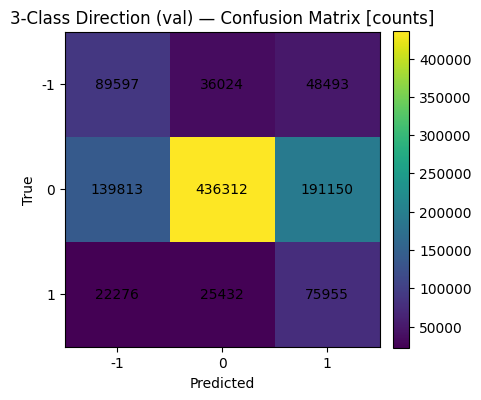

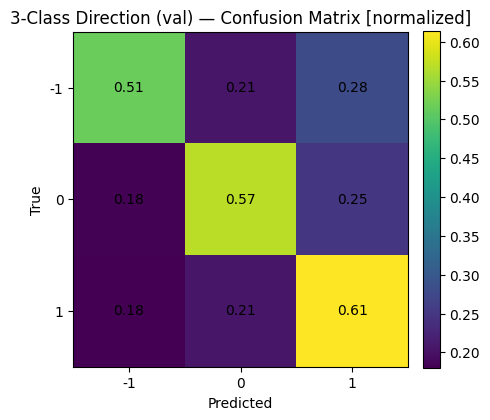

[saved] C:\Users\reyno\Documents\GitHub\Project-BLD\Model_Quality\tcn_confusion_matrix_tcncv.png
[saved] C:\Users\reyno\Documents\GitHub\Project-BLD\Model_Quality\tcn_confusion_matrix_tcncv_norm.png


In [27]:
# --- Cell 10: Validation diagnostics (aligned + confusion matrix plot) ---

# 1) Run unified inference on *validation endpoints only* (already generated earlier)
# If you haven't generated a val-only file yet, run:
# predict_streaming_to_csv(df, _inf_model, _temp_val, out_csv=OUTPUT_PREDICTIONS,
#                          use_fp16_host=False, keep_only_indices=end_indices_val)

preds_val = pd.read_csv(OUTPUT_PREDICTIONS)

# Ensure we have a stable index to align by
if "row_idx" not in preds_val.columns:
    preds_val = preds_val.reset_index().rename(columns={"index": "row_idx"})

# 2) Align predictions to validation endpoints (tolerant to missing)
preds_idxed = preds_val.set_index("row_idx", drop=False)
val_order = pd.Index(end_indices_val.astype(np.int64), name="row_idx")

available = val_order.intersection(preds_idxed.index)
missing   = val_order.difference(preds_idxed.index)
if len(missing) > 0:
    print(f"[warn] {len(missing):,}/{len(val_order):,} val rows missing (likely receptive-field warm-up). "
          "Evaluating on available rows only.")

preds_slice = preds_idxed.loc[available].reindex(available)
y_val_true_slice = y[available.to_numpy()]  # enc 0/1/2 expected

# 3) Metrics
_map = {-1:0, 0:1, 1:2}
y_val_hat_enc = np.array([_map[int(v)] for v in preds_slice["pred_label"].to_numpy()], dtype=int)

from sklearn.metrics import f1_score, confusion_matrix, classification_report
if len(y_val_true_slice) == 0:
    print("[warn] No overlapping validation rows; cannot compute metrics.")
else:
    macro_f1    = f1_score(y_val_true_slice, y_val_hat_enc, average="macro")
    weighted_f1 = f1_score(y_val_true_slice, y_val_hat_enc, average="weighted")
    print("Coverage:", f"{len(available):,}/{len(val_order):,}")
    print("F1 (macro):", round(macro_f1,4), "| F1 (weighted):", round(weighted_f1,4))
    print(classification_report(y_val_true_slice, y_val_hat_enc, target_names=["-1","0","1"], digits=4))

    # 4) Confusion matrices (counts + normalized)
    labels = [0,1,2]  # encoding order for {-1,0,1}
    cm = confusion_matrix(y_val_true_slice, y_val_hat_enc, labels=labels)
    cm_norm = cm / cm.sum(axis=1, keepdims=True).clip(min=1)

    # Plot helper
    def _plot_cm(cm_mat, title, filename):
        fig = plt.figure(figsize=(4.8,4.8))
        ax = plt.gca()
        im = ax.imshow(cm_mat, interpolation="nearest")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        ax.set_title(title)
        ax.set_xticks([0,1,2]); ax.set_xticklabels(["-1","0","1"])
        ax.set_yticks([0,1,2]); ax.set_yticklabels(["-1","0","1"])
        ax.set_xlabel("Predicted"); ax.set_ylabel("True")

        # annotate cells
        if cm_mat.dtype.kind in "iu":  # counts
            for (i, j), v in np.ndenumerate(cm_mat):
                ax.text(j, i, f"{int(v)}", ha="center", va="center")
        else:  # normalized
            for (i, j), v in np.ndenumerate(cm_mat):
                ax.text(j, i, f"{v:.2f}", ha="center", va="center")

        plt.tight_layout()
        fig.savefig(filename, dpi=160)
        plt.show()

    # Save paths
    cm_path_counts = OUTPUT_PLOT  # e.g., "...tcn_confusion_matrix.png"
    cm_path_norm   = cm_path_counts.replace(".png", "_norm.png")

    _plot_cm(cm,      f"3-Class Direction (val) — Confusion Matrix [counts]", cm_path_counts)
    _plot_cm(cm_norm, f"3-Class Direction (val) — Confusion Matrix [normalized]", cm_path_norm)

    print(f"[saved] {cm_path_counts}")
    print(f"[saved] {cm_path_norm}")


In [ ]:
# =========================
# Cell 12 -Backtester (T+1, tradability-aware) — CAUSAL EXEC-FIRST + EXPOSURE CAP + MIN-HOLD
# =========================
from pathlib import Path
import numpy as np
import pandas as pd

PRED_PATH = OUTPUT_PREDICTIONS
TRADE_LOG_PATH = str(config.TCN_TRADE_LOG_CSV)
PLOTS_DIR = str(config.TCN_TRADING_DIR)
Path(PLOTS_DIR).mkdir(parents=True, exist_ok=True)

def run_backtest(
    df_sim: pd.DataFrame,
    *,
    initial_capital: float = 1_000_000_000.0,
    min_trade_amount: float = 10_000_000.0,
    max_trades_per_minute: int = 2,
    min_confidence: float = 0.90,
    exit_profit_threshold: float = 0.20,
    stop_loss_threshold: float = 0.20,
    fee_bps: float = 100,         # roundtrip fee split equally per side
    slippage_bps: float = 0.0,    # extra per side slippage
    spread_bps: float = 10.0,     # synthetic spread if you don't have real bid/ask
    persist_bars: int = 20,       # require k consecutive signals before action
    min_confidence_streak: float = 0.60,   # lenient threshold to build streaks
    median_window: int = 120,     # rolling median window for price stability
    impact_cap_bps: float = 200.0,# max effective move per bar for fills
    max_positions_per_item: int = 1,
    cooldown_minutes: int = 0,
    bar_seconds: int = 60,
    alpha: float = 7.0,
    # NEW: hard exposure cap + min-hold
    per_item_exposure_cap_pct: float = 0.20,   # max % equity per item (mark-to-bid) at ENTRY
    min_hold_minutes: int = 2,                 # minimum minutes before any exit is allowed
):
    """
    Causal backtest with microstructure guards + TRADABILITY GATE:
      • Refuses ENTRY when `tradable==0`.
      • Defers EXIT when `tradable==0` (position remains open).
      • T+1 execution, buys at synthetic ask, sells at synthetic bid.
      • EXEC-FIRST ordering to keep impact-cap causal.
      • Hard per-item exposure cap at BUY time using mark-to-bid.
      • Final forced exits use array state (no stale dict).
    Expects columns: timestamp, item, mid_price, pred_label, pred_proba_buy, (optional) tradable.
    """
    required = {"timestamp","item","mid_price","pred_label","pred_proba_buy"}
    missing = required - set(df_sim.columns)
    if missing:
        raise ValueError(f"Backtest missing columns: {sorted(missing)}")

    has_tradable = "tradable" in df_sim.columns

    # 0) Dedup & strict ordering
    df = (df_sim.sort_values(["timestamp","item"])
                 .drop_duplicates(["item","timestamp"], keep="last")
                 .reset_index(drop=True))

    # 1) Exec time = next bar (T+1)
    df["exec_time"]   = (df["timestamp"] + bar_seconds).astype("float64")
    df["exec_minute"] = (df["exec_time"] // bar_seconds).astype("int64")

    # 2) Rolling median mid per item for stability
    df = df.sort_values(["item","timestamp"], kind="mergesort")
    df["mid_med"] = (df.groupby("item", sort=False)["mid_price"]
                       .rolling(median_window, min_periods=1)
                       .median()
                       .reset_index(level=0, drop=True))

    # 3) State
    capital = float(initial_capital)
    inventory = []          # dicts: item, entry_time, entry_price, size, confidence, entry_minute
    trade_log = []

    half_spread = (spread_bps / 20000.0)
    fee_buy_mult  = 1.0 + (fee_bps / 20000.0) + (slippage_bps / 10000.0)
    fee_sell_mult = 1.0 - (fee_bps / 20000.0) - (slippage_bps / 10000.0)

    equity_rows = []
    current_minute = None
    trades_this_minute = 0

    def minute_of(ts: float) -> int:
        return int(ts // bar_seconds)

    # --- FAST grouping via indices ---
    raw_idx  = df.groupby("timestamp", sort=False).indices
    exec_idx = df.groupby("exec_time", sort=False).indices

    # Pre-extract columns to NumPy once
    ts_arr        = df["timestamp"].to_numpy(dtype=np.float64)
    exec_arr      = df["exec_time"].to_numpy(dtype=np.float64)
    _item_cat     = df["item"].astype("category")
    item_codes    = _item_cat.cat.codes.to_numpy(dtype=np.int32)
    item_categories = _item_cat.cat.categories
    item_to_id    = {str(cat): int(i) for i, cat in enumerate(item_categories)}
    mid_med_arr   = df["mid_med"].to_numpy(dtype=np.float64)
    pred_arr      = df["pred_label"].to_numpy(dtype=np.int8)
    pbuy_arr      = df["pred_proba_buy"].to_numpy(dtype=np.float32)
    tradable_arr  = df["tradable"].to_numpy(dtype=np.int8) if has_tradable else None

    n_items = int(item_codes.max()) + 1

    # Per-item array state
    last_seen_mid         = np.full(n_items, np.nan, dtype=np.float64)
    last_seen_ts          = np.zeros(n_items, dtype=np.float64)
    streak_up_arr         = np.zeros(n_items, dtype=np.int32)
    streak_dn_arr         = np.zeros(n_items, dtype=np.int32)
    last_exit_minute_arr  = np.full(n_items, -10_000_000, dtype=np.int32)

    # Exposure tracking (mark-to-bid)
    per_item_exposure_bid = np.zeros(n_items, dtype=np.float64)  # current value at bid by item
    invested_mark         = 0.0                                  # total invested-at-bid

    # Build global timeline
    timeline = np.unique(np.concatenate([ts_arr, exec_arr]))
    timeline.sort()
    print(f"[bt] steps={len(timeline):,} | rows={len(df):,} | items={n_items:,}")

    # Tail hygiene (no new entries near the end)
    TAIL_BARS = 5  # set 0 to disable
    end_raw_ts  = float(np.nanmax(ts_arr)) if len(ts_arr) else 0.0
    end_exec_ts = float(np.nanmax(exec_arr)) if len(exec_arr) else end_raw_ts

    def snapshot(minute: int, ts: float):
        if minute is None:
            return
        invested = 0.0
        for pos in inventory:
            iid = item_to_id.get(pos["item"], None)
            if iid is None:
                mm = pos["entry_price"]
            else:
                mm = last_seen_mid[iid]
                if not np.isfinite(mm) or mm <= 0:
                    mm = pos["entry_price"]
            bid = mm * (1.0 - half_spread)
            invested += float(pos["size"]) * float(bid)
        equity = capital + invested
        equity_rows.append({
            "minute": minute,
            "timestamp": ts,
            "capital": capital,
            "invested": invested,
            "equity": equity,
            "invested_pct": invested / equity if equity > 0 else 0.0,
            "num_positions": len(inventory),
        })

    # =========================
    # MAIN LOOP (EXEC-FIRST, then RAW update)
    # =========================
    for ts in timeline:
        minute = minute_of(ts)

        # minute snapshot on boundary
        if current_minute is None:
            current_minute = minute; trades_this_minute = 0
        elif minute != current_minute:
            snapshot(current_minute, ts)
            current_minute = minute; trades_this_minute = 0

        # ---- (A) EXEC actions at this exec_time (exits then entries) ----
        eidx = exec_idx.get(ts)
        if eidx is not None:
            # Slice arrays once for this timestamp
            ii    = item_codes[eidx]
            preds = pred_arr[eidx]
            pbuy  = pbuy_arr[eidx]
            midm  = mid_med_arr[eidx]
            trad  = (tradable_arr[eidx] if tradable_arr is not None else None)
            minute = int(ts // bar_seconds)

            # --- Exits first ---
            for j in range(len(eidx)):
                item_id = int(ii[j])
                if trad is not None and int(trad[j]) == 0:
                    continue

                # Signal & streaks
                p_buy = float(pbuy[j])
                p_neg = max(0.0, 1.0 - p_buy)
                if p_buy >= min_confidence_streak and p_buy >= p_neg:
                    sig = 1
                elif p_neg >= min_confidence_streak and p_neg > p_buy:
                    sig = -1
                else:
                    sig = 0

                if sig == 1:
                    streak_up_arr[item_id] += 1; streak_dn_arr[item_id] = 0
                elif sig == -1:
                    streak_up_arr[item_id] = 0;  streak_dn_arr[item_id] += 1
                else:
                    streak_up_arr[item_id] = 0;  streak_dn_arr[item_id] = 0

                # Impact-capped filtered bid from mid_med (CAUSAL: compare vs last_seen_mid from prior bars)
                prev_mid = last_seen_mid[item_id]
                m = float(midm[j])
                if np.isfinite(prev_mid):
                    max_move = (impact_cap_bps / 10000.0)
                    delta = np.clip(m / max(prev_mid, 1e-12), 1.0 - max_move, 1.0 + max_move)
                    m = prev_mid * delta
                bid = m * (1.0 - half_spread)

                item = str(item_categories[item_id])

                updated = []
                for pos in inventory:
                    if pos["item"] != item:
                        updated.append(pos); continue
                    # Enforce min-hold and T+1 (already ensured by exec_time construction, but keep guard)
                    if minute < (pos["entry_minute"] + int(min_hold_minutes)):
                        updated.append(pos); continue

                    entry_price   = pos["entry_price"]
                    mkt_exit_price= bid * fee_sell_mult
                    held_ret      = (mkt_exit_price - entry_price) / entry_price

                    tp_fill_price = entry_price * (1.0 + float(exit_profit_threshold))
                    sl_fill_price = entry_price * (1.0 - float(stop_loss_threshold))

                    flip_ready = (streak_dn_arr[item_id] >= persist_bars)
                    tp_hit     = held_ret >= float(exit_profit_threshold)
                    sl_hit     = held_ret <= -float(stop_loss_threshold)

                    if tp_hit:
                        exit_price = min(mkt_exit_price, tp_fill_price); reason = "tp"
                    elif sl_hit:
                        exit_price = max(mkt_exit_price, sl_fill_price); reason = "sl"
                    else:
                        exit_price = mkt_exit_price; reason = "flip_persist" if flip_ready else None

                    should_exit = tp_hit or sl_hit or flip_ready
                    if should_exit:
                        # exposure decrement (mark-to-bid)
                        ex_bid_val = float(bid) * float(pos["size"])
                        per_item_exposure_bid[item_id] = max(0.0, per_item_exposure_bid[item_id] - ex_bid_val)
                        invested_mark = max(0.0, invested_mark - ex_bid_val)

                        pnl = (exit_price - entry_price) * pos["size"]
                        capital += pos["size"] * exit_price
                        dur_sec = float(ts - pos["entry_time"])
                        trade_log.append({
                            "item": item,
                            "entry_time": pos["entry_time"],
                            "exit_time": ts,
                            "duration_sec": dur_sec,
                            "duration_min": dur_sec / 60.0,
                            "entry_price": entry_price,
                            "exit_price": exit_price,
                            "size": pos["size"],
                            "pnl": pnl,
                            "return": (exit_price - entry_price) / entry_price,
                            "confidence": pos["confidence"],
                            "reason": reason
                        })
                        last_exit_minute_arr[item_id] = minute
                    else:
                        updated.append(pos)
                inventory = updated

            # --- Entries after exits ---
            if not (TAIL_BARS > 0 and ts >= end_exec_ts - TAIL_BARS * bar_seconds):
                for j in range(len(eidx)):
                    item_id = int(ii[j])
                    if trad is not None and int(trad[j]) == 0:
                        continue

                    # score_buy: P(+1) minus P(-1) fallback
                    p_buy = float(pbuy[j])
                    p_neg = max(0.0, 1.0 - p_buy)
                    score_buy = p_buy - p_neg
                    if np.isnan(score_buy) or score_buy < 0.0:
                        continue

                    conf = p_buy
                    if conf < min_confidence or trades_this_minute >= max_trades_per_minute:
                        continue
                    if cooldown_minutes > 0 and (minute - last_exit_minute_arr[item_id]) < cooldown_minutes:
                        continue
                    if streak_up_arr[item_id] < persist_bars:
                        continue

                    # Impact-capped filtered ask from mid_med (CAUSAL)
                    prev_mid = last_seen_mid[item_id]
                    m = float(midm[j])
                    if np.isfinite(prev_mid):
                        max_move = (impact_cap_bps / 10000.0)
                        delta = np.clip(m / max(prev_mid, 1e-12), 1.0 - max_move, 1.0 + max_move)
                        m = prev_mid * delta
                    ask = m * (1.0 + half_spread)
                    entry_price = ask * fee_buy_mult
                    if entry_price <= 0:
                        continue

                    # Disallow entries that cannot meet min hold before data end
                    if (ts + min_hold_minutes * bar_seconds) > end_exec_ts:
                        continue

                    # Position cap: count current opens
                    item = str(item_categories[item_id])
                    n_open = sum(1 for p in inventory if p["item"] == item)
                    if n_open >= max_positions_per_item:
                        continue

                    # --- per-item exposure cap (mark-to-bid) ---
                    current_equity = capital + invested_mark
                    if current_equity <= 0.0:
                        continue
                    cap_value = float(per_item_exposure_cap_pct) * current_equity
                    bid_now  = m * (1.0 - half_spread)
                    remaining_value = cap_value - per_item_exposure_bid[item_id]
                    if remaining_value <= 0.0:
                        continue  # already at/over cap

                    # budget sizing from confidence
                    scaled = ((conf - min_confidence) / max(1e-6, 1.0 - min_confidence)) ** alpha
                    budget = float(scaled * capital)
                    if budget < min_trade_amount:
                        continue
                    size = int(budget / entry_price)
                    if size < 1:
                        continue

                    # clamp by remaining per-item headroom
                    max_size_by_cap = int(remaining_value // max(bid_now, 1e-12))
                    if max_size_by_cap <= 0:
                        continue
                    if size > max_size_by_cap:
                        size = max_size_by_cap
                    if size < 1:
                        continue

                    # Open position
                    capital -= size * entry_price
                    inventory.append({
                        "item": item,
                        "entry_time": ts,
                        "entry_minute": minute,
                        "entry_price": entry_price,
                        "size": size,
                        "confidence": conf
                    })

                    # exposure increment (mark-to-bid)
                    trade_bid_val = bid_now * size
                    per_item_exposure_bid[item_id] += trade_bid_val
                    invested_mark += trade_bid_val

                    # reset streaks for this item after entry
                    streak_dn_arr[item_id] = 0
                    streak_up_arr[item_id] = 0

                    last_seen_mid[item_id] = m
                    last_seen_ts[item_id]  = ts
                    trades_this_minute += 1

        # ---- (B) RAW UPDATE after exec: update last_seen from raw rows at this timestamp ----
        ridx = raw_idx.get(ts)
        if ridx is not None:
            ii = item_codes[ridx]
            mm = mid_med_arr[ridx]
            last_seen_mid[ii] = mm
            last_seen_ts[ii]  = ts

    # Final snapshot and forced exits at bid (uses array state)
    if current_minute is not None and len(df):
        snapshot(current_minute, float(df["timestamp"].iloc[-1]))

    for pos in inventory:
        iid = item_to_id.get(pos["item"], None)
        if iid is None:
            mm = pos["entry_price"]
            last_time = pos["entry_time"]
        else:
            mm = last_seen_mid[iid]
            if not np.isfinite(mm) or mm <= 0:
                mm = pos["entry_price"]
            last_time = last_seen_ts[iid]
            if not np.isfinite(last_time) or last_time <= 0:
                last_time = pos["entry_time"]

        # ensure exit strictly after entry (T+1)
        exit_time = max(float(last_time), float(pos["entry_time"]) + float(bar_seconds))
        bid = float(mm) * (1.0 - half_spread)
        exit_price = bid * fee_sell_mult
        pnl = (exit_price - pos["entry_price"]) * pos["size"]
        capital += pos["size"] * exit_price
        dur_sec = float(exit_time - pos["entry_time"])
        trade_log.append({
            "item": pos["item"],
            "entry_time": pos["entry_time"],
            "exit_time": exit_time,
            "duration_sec": dur_sec,
            "duration_min": dur_sec / 60.0,
            "entry_price": pos["entry_price"],
            "exit_price": exit_price,
            "size": pos["size"],
            "pnl": pnl,
            "return": (exit_price - pos["entry_price"]) / pos["entry_price"],
            "confidence": pos["confidence"],
            "reason": "final_close"
        })

    # Build DataFrames safely even if there are zero trades / snapshots
    if len(trade_log) > 0:
        trades = pd.DataFrame(trade_log).sort_values("pnl", ascending=False).reset_index(drop=True)
    else:
        trades = pd.DataFrame(columns=[
            "item","entry_time","exit_time","duration_sec","duration_min",
            "entry_price","exit_price","size","pnl","return","confidence","reason"
        ])

    if len(equity_rows) > 0:
        eq = pd.DataFrame(equity_rows).sort_values("minute").reset_index(drop=True)
    else:
        eq = pd.DataFrame(columns=["minute","timestamp","capital","invested","equity","invested_pct","num_positions"])

    # Invariants
    if len(trades):
        assert (trades["exit_time"] > trades["entry_time"]).all(), "Exit must be strictly after entry (T+1)."
        if (trades["return"] > 1.0).any():
            print("[WARN] Trades with >100% return detected — check timestamp units and price scaling.")

    # Summary
    gross_profit = trades.loc[trades["pnl"] > 0, "pnl"].sum()
    gross_loss   = trades.loc[trades["pnl"] < 0, "pnl"].sum()
    avg_win = trades.loc[trades["pnl"] > 0, "return"].mean() if (trades["pnl"] > 0).any() else 0.0
    avg_loss = trades.loc[trades["pnl"] < 0, "return"].mean() if (trades["pnl"] < 0).any() else 0.0
    avg_duration = trades["duration_min"].mean() if len(trades) else 0.0

    summary = {
        "Final Capital": f"{capital:,.0f}",
        "Total Profit": f"{capital - initial_capital:,.0f}",
        "Num Trades": len(trades),
        "Win Rate": f"{(trades['pnl']>0).mean():.2%}" if len(trades) else "n/a",
        "Average Return / Trade": f"{trades['return'].mean():.2%}" if len(trades) else "n/a",
        "Average Win": f"{avg_win:.2%}",
        "Average Loss": f"{avg_loss:.2%}",
        "Gross Profit": f"{gross_profit:,.0f}",
        "Gross Loss": f"{gross_loss:,.0f}",
        "Profit Factor": f"{abs(gross_profit/gross_loss):.2f}" if gross_loss < 0 else "∞",
        "Average Duration (min)": f"{avg_duration:.2f}",
    }

    return trades, summary, eq

# --- Load predictions and enforce single row per (item,timestamp)
preds = pd.read_csv(PRED_PATH)
preds = preds.sort_values(["timestamp","item"]).drop_duplicates(["item","timestamp"], keep="last")
# Safety: ensure columns exist
if "pred_label" not in preds.columns and "pred_dir" in preds.columns:
    preds["pred_label"] = preds["pred_dir"].astype("int8")
if "pred_proba_buy" not in preds.columns:
    if "proba_1" in preds.columns:
        preds["pred_proba_buy"] = preds["proba_1"].astype("float32")
    else:
        preds["pred_proba_buy"] = (preds["pred_label"] == 1).astype("float32")
if "tradable" not in preds.columns:
    preds["tradable"] = 1






PRED_PATH = C:\Users\reyno\Documents\GitHub\Project-BLD\Outputs\tcn_predictions.csv
  size: 69058119 bytes  mtime: 1759000896.1899047
  sha256(file): 985982847a6e2f5bbe736f8a960a84d34921e106c556a46700c2541a78ac4ee6
inline preds fingerprint: (1062206, np.float64(1757709700.0), np.float64(1758162400.0), 572, 'fe6290f7f452dcc15700cc077c9ab55df42d51ec90fa511758cae3ee68e39a8e')
disk/_load_preds fingerprint: (1062206, np.float64(1757709700.0), np.float64(1758162400.0), 572, 'fe6290f7f452dcc15700cc077c9ab55df42d51ec90fa511758cae3ee68e39a8e')
[OK] Inline and disk preds are identical (backtests should match given same kwargs).


In [28]:
# ===== Parallel backtest tuning via joblib (loky) =====
import os, numpy as np, pandas as pd, optuna, warnings
from joblib import Parallel, delayed

STUDY_NAME = "bt_knobs_v18"
import os

DB_DIR = os.path.join(os.getcwd(), "backtests", "db")
os.makedirs(DB_DIR, exist_ok=True)

STORAGE = f"sqlite:///{os.path.join(DB_DIR, f'{STUDY_NAME}.db')}"

TOTAL_TRIALS = 200
N_WORKERS    = min(os.cpu_count(), 32)

# Keep BLAS libs from oversubscribing inside each worker
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

# --- objective that loads its own preds (no notebook globals) ---
def _load_preds():
    dfp = pd.read_csv(PRED_PATH)
    dfp = dfp.sort_values(["timestamp","item"]).drop_duplicates(["item","timestamp"], keep="last")
    if "pred_label" not in dfp.columns and "pred_dir" in dfp.columns:
        dfp["pred_label"] = dfp["pred_dir"].astype("int8")
    if "pred_proba_buy" not in dfp.columns:
        if "proba_1" in dfp.columns:
            dfp["pred_proba_buy"] = dfp["proba_1"].astype("float32")
        else:
            dfp["pred_proba_buy"] = (dfp["pred_label"] == 1).astype("float32")
    if "tradable" not in dfp.columns:
        dfp["tradable"] = 1
    return dfp

import numpy as np, pandas as pd, inspect, traceback, math

def _days_in_preds(preds_df: pd.DataFrame) -> float:
    if len(preds_df) == 0: return 1.0
    t0 = float(preds_df["timestamp"].min())
    t1 = float(preds_df["timestamp"].max())
    days = max( (t1 - t0) / 86400.0, 1e-6 )
    return days

def _bt_objective(trial, preds_local: pd.DataFrame):
    # ----  knobs  ----
    sampled = {
        "min_trade_amount":      trial.suggest_float("min_trade_amount", 5e6, 5e7, log=True),
        "min_confidence":        trial.suggest_float("min_confidence", 0.55, 0.95),
        "exit_profit_threshold": trial.suggest_float("exit_profit_threshold", 0.02, 0.40),
        "stop_loss_threshold":   trial.suggest_float("stop_loss_threshold", 0.02, 0.40),
        "persist_bars":          trial.suggest_int("persist_bars", 1, 30),
        "alpha":                 trial.suggest_float("alpha", 1.0, 12.0),
        "min_confidence_streak": trial.suggest_float("min_confidence_streak", 0.50, 0.80),
    }

    # Only pass args your run_backtest accepts (handles older signatures safely)
    try:
        allowed = set(inspect.signature(run_backtest).parameters.keys())
        bt_kwargs = {k: v for k, v in sampled.items() if k in allowed}
    except Exception:
        bt_kwargs = sampled

    # ---- compute target trade count from data span ----
    days = _days_in_preds(preds_local)
    target_trades = max(1.0, 25.0 * days)     # round-trips/day 
    sigma = max(1.0, 0.40 * target_trades)    # ~40% width around the target

    try:
        # ---- run backtest ----
        trades, summary, eq = run_backtest(
            preds_local,
            initial_capital=1_000_000_000.0,
            max_trades_per_minute=2,
            spread_bps=10.0,
            fee_bps=100.0,
            slippage_bps=0.0,
            median_window=120,
            impact_cap_bps=200.0,
            max_positions_per_item=1,
            cooldown_minutes=0,
            bar_seconds=60,
            **bt_kwargs
        )

        ntr = len(trades)  # round-trips
        if ntr == 0:
            return -1e9  # avoid “best” being a zero-trade config

        # ---- extract PF and profit ----
        pf_txt = summary.get("Profit Factor", "0")
        pf = float("inf") if pf_txt == "∞" else float(pf_txt)
        if not np.isfinite(pf) or pf <= 0:
            # fallback to total profit (normalized) to keep gradients informative
            tot_profit = float(summary.get("Total Profit", "0").replace(",", "")) if "Total Profit" in summary else 0.0
            pf = max(tot_profit / 1_000_000_000.0, 0.0)  # normalize by initial_capital

        # ---- trade-count shaping (Gaussian centered at target_trades) ----
        trade_weight = math.exp(-0.5 * ((ntr - target_trades) / sigma) ** 2)

        # ---- light profit nudge to break ties between similar PFs ----
        try:
            tot_profit = float(summary.get("Total Profit", "0").replace(",", ""))
        except Exception:
            tot_profit = 0.0
        profit_nudge = 1.0 + .5 * max(tot_profit / 1_000_000_000.0, 0.0)  # +15% per +100% capital return, clipped by data reality

        # ---- final score ----
        score = float(pf * trade_weight * profit_nudge)

        # (optional) very small penalty if trades are wildly high to deter churny edges
        if ntr > 4.0 * target_trades:
            score *= 0.90

        return score

    except Exception:
        traceback.print_exc()
        return -1e12


# Create the study in the DB first (idempotent)
_ = optuna.create_study(study_name=STUDY_NAME, storage=STORAGE,
                        direction="maximize", load_if_exists=True,
                        sampler=optuna.samplers.TPESampler(seed=42))

def _worker_chunk(n_trials):
    preds_local = _load_preds()  # load once per worker
    study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE)
    study.optimize(lambda tr: _bt_objective(tr, preds_local),
                   n_trials=n_trials, n_jobs=1, gc_after_trial=True, catch=(Exception,))


# Split trials across workers and launch via joblib (loky backend uses processes)
per = TOTAL_TRIALS // N_WORKERS
rem = TOTAL_TRIALS % N_WORKERS
trial_counts = [per + (1 if i < rem else 0) for i in range(N_WORKERS)]
trial_counts = [c for c in trial_counts if c > 0]

Parallel(n_jobs=N_WORKERS, backend="loky")(delayed(_worker_chunk)(c) for c in trial_counts)

# Read best result
study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE)
completed = [t for t in study.get_trials(deepcopy=False) if t.state == optuna.trial.TrialState.COMPLETE]
print(f"[optuna] completed trials: {len(completed)}")
print("Best params:", study.best_params)
print("Best value:", study.best_value)

# Optional: final backtest with best params
best_trades, best_summary, best_eq = run_backtest(_load_preds(), **{k:v for k,v in study.best_params.items()
                                                                    if k in run_backtest.__code__.co_varnames})
print("Summary:", best_summary)
best_trades.to_csv(TRADE_LOG_PATH, index=False)


[I 2025-09-27 14:36:59,628] A new study created in RDB with name: bt_knobs_v18


[optuna] completed trials: 200
Best params: {'min_trade_amount': 31752775.96016691, 'min_confidence': 0.7379094634339518, 'exit_profit_threshold': 0.3709511882200763, 'stop_loss_threshold': 0.031171702990184454, 'persist_bars': 30, 'alpha': 2.912848493939517, 'min_confidence_streak': 0.743539882397886}
Best value: 4.143390457855618
[bt] steps=7,068 | rows=1,062,206 | items=572
Summary: {'Final Capital': '1,814,223,080', 'Total Profit': '814,223,080', 'Num Trades': 107, 'Win Rate': '28.04%', 'Average Return / Trade': '6.91%', 'Average Win': '32.20%', 'Average Loss': '-2.94%', 'Gross Profit': '1,172,196,260', 'Gross Loss': '-357,973,180', 'Profit Factor': '3.27', 'Average Duration (min)': '436.32'}


In [52]:
# --- Run backtest (tweak fees/slippage here)
trades, summary, equity = run_backtest(
    preds,
    fee_bps=100,
    slippage_bps=0.0,
    cooldown_minutes=0,
    max_trades_per_minute=2,
    max_positions_per_item=1,
    median_window=120,
    bar_seconds=60,
    spread_bps=10,
    min_trade_amount=31752775.96016691,
    min_confidence=0.7379094634339518, 
    persist_bars=30,
    exit_profit_threshold=0.3709511882200763,
    alpha=2.912848493939517,
    stop_loss_threshold=0.031171702990184454,
    min_confidence_streak=0.743539882397886,
    per_item_exposure_cap_pct=.2,
)

# Save trade log
Path(os.path.dirname(str(config.TCN_TRADE_LOG_CSV))).mkdir(parents=True, exist_ok=True)
trades.to_csv(str(config.TCN_TRADE_LOG_CSV), index=False)

print("[Backtest summary]")
for k, v in summary.items():
    print(f"{k}: {v}")


[bt] steps=7,068 | rows=1,062,206 | items=572
[Backtest summary]
Final Capital: 1,814,223,080
Total Profit: 814,223,080
Num Trades: 107
Win Rate: 28.04%
Average Return / Trade: 6.91%
Average Win: 32.20%
Average Loss: -2.94%
Gross Profit: 1,172,196,260
Gross Loss: -357,973,180
Profit Factor: 3.27
Average Duration (min): 436.32


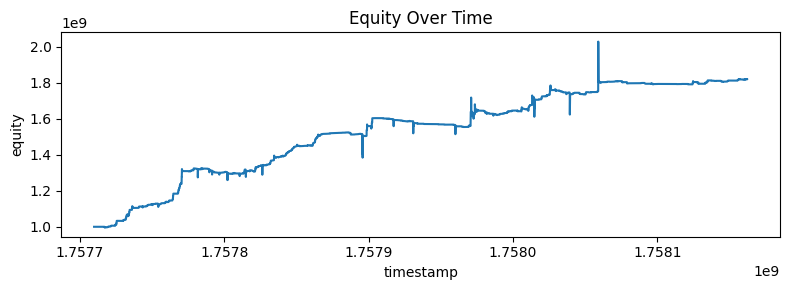

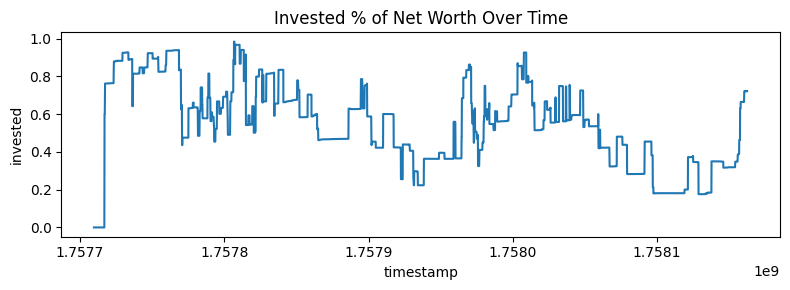

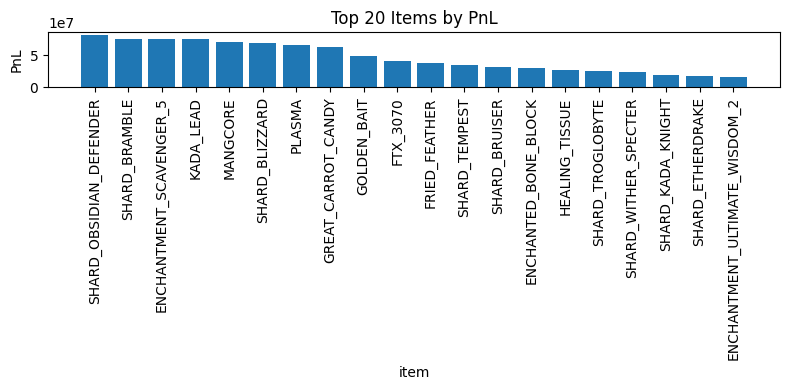

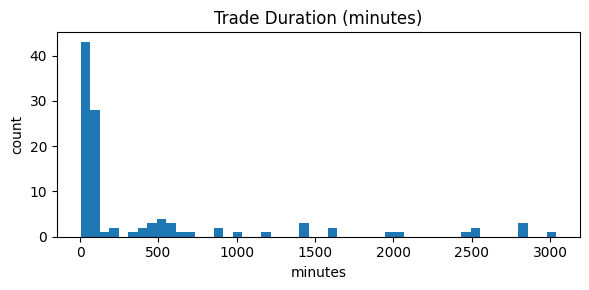

In [53]:
# --- Plots

# 1) Equity curve over time
fig = plt.figure(figsize=(8,3))
ax = plt.gca()
ax.plot(equity["timestamp"].values, equity["equity"].values)
ax.set_title("Equity Over Time")
ax.set_xlabel("timestamp")
ax.set_ylabel("equity")
plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "equity_curve.png"), dpi=160)
plt.show()

# 2) Capital invested over time
fig = plt.figure(figsize=(8,3))
ax = plt.gca()
ax.plot(equity["timestamp"].values, equity["invested_pct"].values)
ax.set_title("Invested % of Net Worth Over Time")
ax.set_ylabel("invested")
ax.set_xlabel("timestamp")
plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "invested_curve.png"), dpi=160)
plt.show()

# 3) Top profit items (bar)
topN = 20
pnl_by_item = trades.groupby("item", as_index=False)["pnl"].sum().sort_values("pnl", ascending=False).head(topN)
fig = plt.figure(figsize=(8,4))
ax = plt.gca()
ax.bar(range(len(pnl_by_item)), pnl_by_item["pnl"].values)
ax.set_xticks(range(len(pnl_by_item)))
ax.set_xticklabels(pnl_by_item["item"].values, rotation=90)
ax.set_title(f"Top {topN} Items by PnL")
ax.set_xlabel("item")
ax.set_ylabel("PnL")
plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "top_items_pnl.png"), dpi=160)
plt.show()

# 4) Trade duration histogram (minutes)
if len(trades):
    dur_min = (trades["exit_time"].values - trades["entry_time"].values) / 60.0
    fig = plt.figure(figsize=(6,3))
    ax = plt.gca()
    ax.hist(dur_min, bins=50)
    ax.set_title("Trade Duration (minutes)")
    ax.set_xlabel("minutes")
    ax.set_ylabel("count")
    plt.tight_layout()
    fig.savefig(os.path.join(PLOTS_DIR, "trade_duration_hist.png"), dpi=160)
    plt.show()



In [ ]:
# --- Forensic check: verify fills are causal & sane (TCN) ---

import pandas as pd
import numpy as np
import os

# 1) Locate the trade log (prefer notebook variable TRADE_LOG_PATH; else config TCN; else XGB->TCN swap)
paths_to_try = []
if 'TRADE_LOG_PATH' in globals():
    paths_to_try.append(str(TRADE_LOG_PATH))
if hasattr(config, 'TCN_TRADE_LOG_CSV'):
    paths_to_try.append(str(config.TCN_TRADE_LOG_CSV))
# last resort: swap xgb->tcn on the XGB path if present
if hasattr(config, 'XGB_TRADE_LOG_CSV'):
    paths_to_try.append(str(config.XGB_TRADE_LOG_CSV).replace("xgb", "tcn"))

trade_path = next((p for p in paths_to_try if p and os.path.exists(p)), None)
if trade_path is None:
    raise FileNotFoundError(f"Could not find a TCN trade log. Tried: {paths_to_try}")

tr = pd.read_csv(trade_path)
tr = tr.sort_values(["item","entry_time"]).reset_index(drop=True)

# 2) Use your in-memory df (masked, leak-proof) as the reference tape
#    and make sure the columns exist. If target_* columns are missing, we’ll just skip those checks.
ref_cols = ["item","timestamp","mid_price"]
has_tmax = "target_max_abs" in df.columns
has_tmin = "target_min_abs" in df.columns
if has_tmax: ref_cols.append("target_max_abs")
if has_tmin: ref_cols.append("target_min_abs")

df_ref = df[ref_cols].copy()

# 3) Normalize dtypes for the merge: trades tend to store times as float; df has ints
for c in ["entry_time","exit_time"]:
    if c in tr.columns:
        tr[c] = tr[c].astype(np.int64)

df_ref["timestamp"] = df_ref["timestamp"].astype(np.int64)

# 4) Join the tape row at the entry time for each trade
probe = tr.merge(
    df_ref,
    left_on=["item","entry_time"],
    right_on=["item","timestamp"],
    how="left",
    suffixes=("","_at_entry")
)

# 5) Compute diagnostics (only where we have the reference row)
if "mid_price" in probe.columns:
    # If the tape row at entry_time is missing (NaN), flag it
    missing_mask = probe["mid_price"].isna()
    if missing_mask.any():
        print(f"[forensic] Missing reference tape rows for {int(missing_mask.sum())} trade(s) at their entry_time.")

    # Compare exit price vs mid at entry (same-bar fill check)
    probe["exit_equals_mid_at_entry"] = np.isclose(
        probe["exit_price"].astype(float),
        probe["mid_price"].astype(float),
        rtol=1e-6, atol=1e-6
    )
else:
    probe["exit_equals_mid_at_entry"] = False

if has_tmax:
    probe["exit_matches_future_max"] = np.isclose(
        probe["exit_price"].astype(float),
        probe["target_max_abs"].astype(float),
        rtol=1e-6, atol=1e-6
    )
else:
    probe["exit_matches_future_max"] = np.nan

if has_tmin:
    probe["exit_matches_future_min"] = np.isclose(
        probe["exit_price"].astype(float),
        probe["target_min_abs"].astype(float),
        rtol=1e-6, atol=1e-6
    )
else:
    probe["exit_matches_future_min"] = np.nan

# 6) Summary counts
cols = ["exit_equals_mid_at_entry","exit_matches_future_max","exit_matches_future_min"]
present = [c for c in cols if c in probe.columns]
print("Counts:", probe[present].sum(numeric_only=True).to_dict())

# 7) Suspicious: zero-duration (shouldn’t happen with strict T+1) and not equal to mid at entry
sus = probe[(probe["exit_time"] == probe["entry_time"]) & (~probe["exit_equals_mid_at_entry"].fillna(False))]
print(f"Suspicious same-timestamp trades: {len(sus)}")
display(sus.head(10))


[forensic] Missing reference tape rows for 765 trade(s) at their entry_time.
Counts: {'exit_equals_mid_at_entry': 0, 'exit_matches_future_max': 0, 'exit_matches_future_min': 0}
Suspicious same-timestamp trades: 0


,item,entry_time,exit_time,duration_sec,duration_min,entry_price,exit_price,size,pnl,return,confidence,reason,timestamp,mid_price,target_max_abs,target_min_abs,exit_equals_mid_at_entry,exit_matches_future_max,exit_matches_future_min


In [41]:
# Replace Cell 24: plot_item_feature with a causal, exec-aligned version
def plot_item_exec_causal(
    df_any: pd.DataFrame,
    item_name: str,
    *,
    feature: str = "mid_price",
    median_window: int = 120,
    impact_cap_bps: float = 200.0,
    spread_bps: float = 10.0,
    fee_bps: float = 100.0,
    slippage_bps: float = 0.0,
    bar_seconds: int = 60,
    n_points: int | None = None,
    show_raw: bool = True,
    show_median: bool = True,
    overlay_trades: pd.DataFrame | None = None,   # pass your trade log slice for this item if you want markers
):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt

    dfi = df_any[df_any.get("item","") == item_name].copy()
    dfi = dfi.sort_values("timestamp", kind="mergesort").reset_index(drop=True)
    if dfi.empty:
        print(f"No data found for item {item_name}")
        return
    if feature not in dfi.columns:
        raise ValueError(f"feature '{feature}' not in df")

    # rolling median identical to BT (per item)
    dfi["mid_med"] = (
        dfi[feature]
        .rolling(median_window, min_periods=1)
        .median()
        .astype("float64")
    )

    # Build exec_time (T+1) and per-event lookups
    dfi["exec_time"] = (dfi["timestamp"].astype("float64") + float(bar_seconds))
    midmed_by_exec = dict(zip(dfi["exec_time"].values, dfi["mid_med"].values))
    midmed_by_ts   = dict(zip(dfi["timestamp"].values, dfi["mid_med"].values))

    # causal parameters
    half_spread   = spread_bps / 20000.0
    fee_buy_mult  = 1.0 + (fee_bps / 20000.0) + (slippage_bps / 10000.0)
    fee_sell_mult = 1.0 - (fee_bps / 20000.0) - (slippage_bps / 10000.0)
    max_move      = impact_cap_bps / 10000.0

    # Build full per-item timeline and sweep with EXEC-first then RAW update
    timeline = np.unique(np.concatenate([dfi["timestamp"].values, dfi["exec_time"].values])).astype("float64")
    timeline.sort()

    last_seen_mid = np.nan

    t_exec_vec, mid_imp_vec, bid_fee_vec, ask_fee_vec = [], [], [], []
    for ts in timeline:
        # (A) EXEC at exec_time==ts
        m_prevbar = midmed_by_exec.get(ts)
        if m_prevbar is not None:
            if np.isfinite(last_seen_mid):
                ratio = float(m_prevbar) / max(last_seen_mid, 1e-12)
                ratio = np.clip(ratio, 1.0 - max_move, 1.0 + max_move)
                m_imp = last_seen_mid * ratio
            else:
                m_imp = float(m_prevbar)
            bid_gross = m_imp * (1.0 - half_spread)
            ask_gross = m_imp * (1.0 + half_spread)

            t_exec_vec.append(ts)
            mid_imp_vec.append(m_imp)
            bid_fee_vec.append(bid_gross * fee_sell_mult)
            ask_fee_vec.append(ask_gross * fee_buy_mult)

        # (B) RAW update at timestamp==ts
        mm_raw = midmed_by_ts.get(ts)
        if mm_raw is not None:
            last_seen_mid = float(mm_raw)

    # Optional tail trimming for display (after constructing the full causal series)
    if n_points is not None and n_points > 0:
        t_exec_vec = t_exec_vec[-n_points:]
        mid_imp_vec = mid_imp_vec[-n_points:]
        bid_fee_vec = bid_fee_vec[-n_points:]
        ask_fee_vec = ask_fee_vec[-n_points:]

    # ----- Plot -----
    fig, ax = plt.subplots(figsize=(12,5))

    # raw & median at RAW timestamps (visual context only)
    if show_raw:
        ax.plot(pd.to_datetime(dfi["timestamp"], unit="s"),
                dfi[feature].values, alpha=0.35, linewidth=0.8, label=f"raw {feature}")
    if show_median:
        ax.plot(pd.to_datetime(dfi["timestamp"], unit="s"),
                dfi["mid_med"].values, linewidth=1.4, alpha=0.9, label=f"median({median_window}) @RAW")

    # causal, exec-aligned series
    t_exec_dt = pd.to_datetime(np.array(t_exec_vec), unit="s")
    ax.plot(t_exec_dt, mid_imp_vec, linewidth=1.3, label="mid_impacted @EXEC")
    ax.plot(t_exec_dt, bid_fee_vec, linewidth=1.0, label="synthetic bid (fees) @EXEC")
    ax.plot(t_exec_dt, ask_fee_vec, linewidth=1.0, label="synthetic ask (fees) @EXEC")

    # optional: overlay trade markers from the trade log for this item
    if overlay_trades is not None and len(overlay_trades):
        tri = overlay_trades[overlay_trades["item"] == item_name]
        if len(tri):
            ax.scatter(pd.to_datetime(tri["entry_time"].values, unit="s"),
                       tri["entry_price"].values, marker="^", s=60, label="logged entry")
            ax.scatter(pd.to_datetime(tri["exit_time"].values, unit="s"),
                       tri["exit_price"].values, marker="v", s=60, label="logged exit")

    ax.set_title(f"{item_name} — causal exec-aligned fills vs raw/median")
    ax.set_xlabel("time"); ax.set_ylabel("price")
    ax.grid(alpha=0.3); ax.legend(loc="best")
    plt.show()


In [1]:
preds_loaded = pd.read_csv(OUTPUT_PREDICTIONS).sort_values(["timestamp","item"]).drop_duplicates(["item","timestamp"], keep="last")
trades_logged = pd.read_csv(str(config.TCN_TRADE_LOG_CSV))  # after running BT

plot_item_exec_causal(
    preds_loaded, "ENCHANTMENT_SCAVENGER_5",
    feature="mid_price",
    median_window=120,
    impact_cap_bps=200.0,
    spread_bps=10.0,
    fee_bps=100.0,
    slippage_bps=0.0,
    bar_seconds=60,
    n_points=2000,
    overlay_trades=trades_logged,
)


NameError: name 'pd' is not defined